# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
#import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
X_train = np.load('data/x_train.npy')
y_train = np.load('data/y_train.npy')

X_test = np.load('data/x_test.npy')
y_test = np.load('data/y_test.npy')

X_val = np.load('data/x_val.npy')
y_val = np.load('data/y_val.npy')

# PCA FS

In [29]:
from sklearn.decomposition import PCA

def pca_feature_selection(X, k, explained_variance_threshold=0.95):

    pca = PCA()
    pca.fit(X)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= explained_variance_threshold) + 1
    print(f'components: {n_components}')
    

    pca = PCA(n_components=n_components)
    pca.fit(X)

    feature_importance = np.abs(pca.components_).sum(axis=0)
    top_k_indices = np.argsort(feature_importance)[-k:]
    
    return top_k_indices

k = 31
top_k_features = pca_feature_selection(X_train, k)

components: 10


In [30]:
top_features_indices = top_k_features
np.sort(top_features_indices)

array([ 0,  1,  5,  7,  8,  9, 10, 11, 18, 23, 24, 25, 26, 27, 28, 30, 32,
       33, 34, 35, 42, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57])

In [8]:
X_train_selected = X_train[:, top_features_indices]
X_test_selected = X_test[:, top_features_indices]
X_val_selected = X_val[:, top_features_indices]

In [9]:
y_train = np.where(y_train == 11, 0, 1)
y_test = np.where(y_test == 11, 0, 1)
y_val = np.where(y_val == 11, 0, 1)

# PyDeepInsight

In [10]:
from pyDeepInsight import ImageTransformer

In [11]:
it = ImageTransformer(
    pixels=8,
    feature_extractor='tsne',
    discretization='lsa'
)

In [12]:
it.fit(X_train_selected)
X_train_images = it.transform(X_train_selected, 'pytorch')

X_test_images = it.transform(X_test_selected, 'pytorch')

X_val_images = it.transform(X_val_selected, 'pytorch')

In [13]:
def display_first_k_images(images, k, labels=None, target_label=None):

    if labels is not None and target_label is not None:
        # Handle both NumPy arrays and PyTorch tensors
        if isinstance(labels, torch.Tensor):
            indices = (labels == target_label).nonzero(as_tuple=True)[0]
        else:  # Assume labels is a NumPy array
            indices = (labels == target_label).nonzero()[0]
        images = images[indices]

    k = min(k, images.shape[0])

    cols = min(10, k) 
    rows = (k + cols - 1) // cols 

    plt.figure(figsize=(cols * 2, rows * 2))
    
    for i in range(k):
        plt.subplot(rows, cols, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


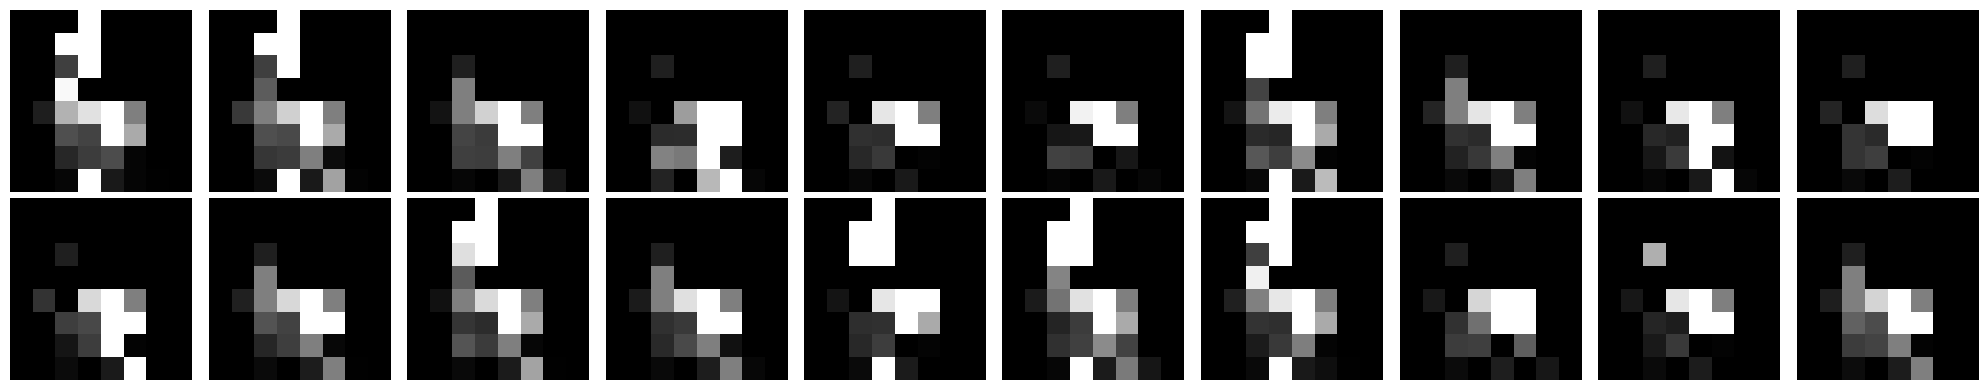

In [14]:
display_first_k_images(X_train_images, 20, y_train, target_label=0)

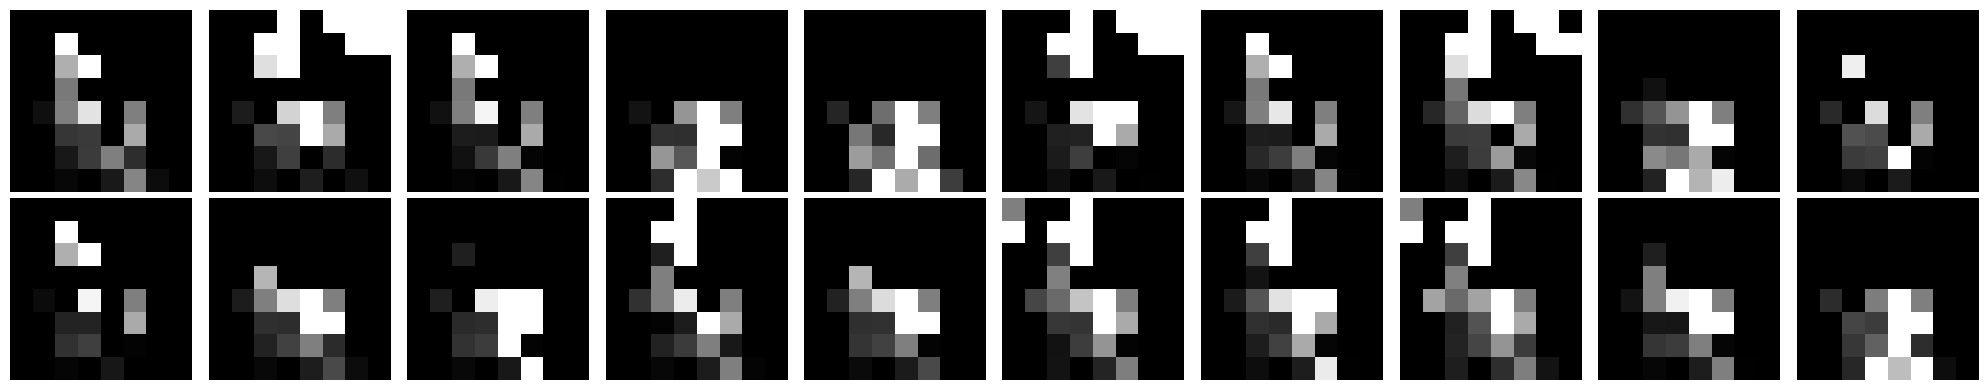

In [16]:
display_first_k_images(X_train_images, 20, y_train, target_label=1)

In [19]:
X_train_images.shape

torch.Size([448735, 3, 8, 8])

TypeError: 'NoneType' object is not subscriptable

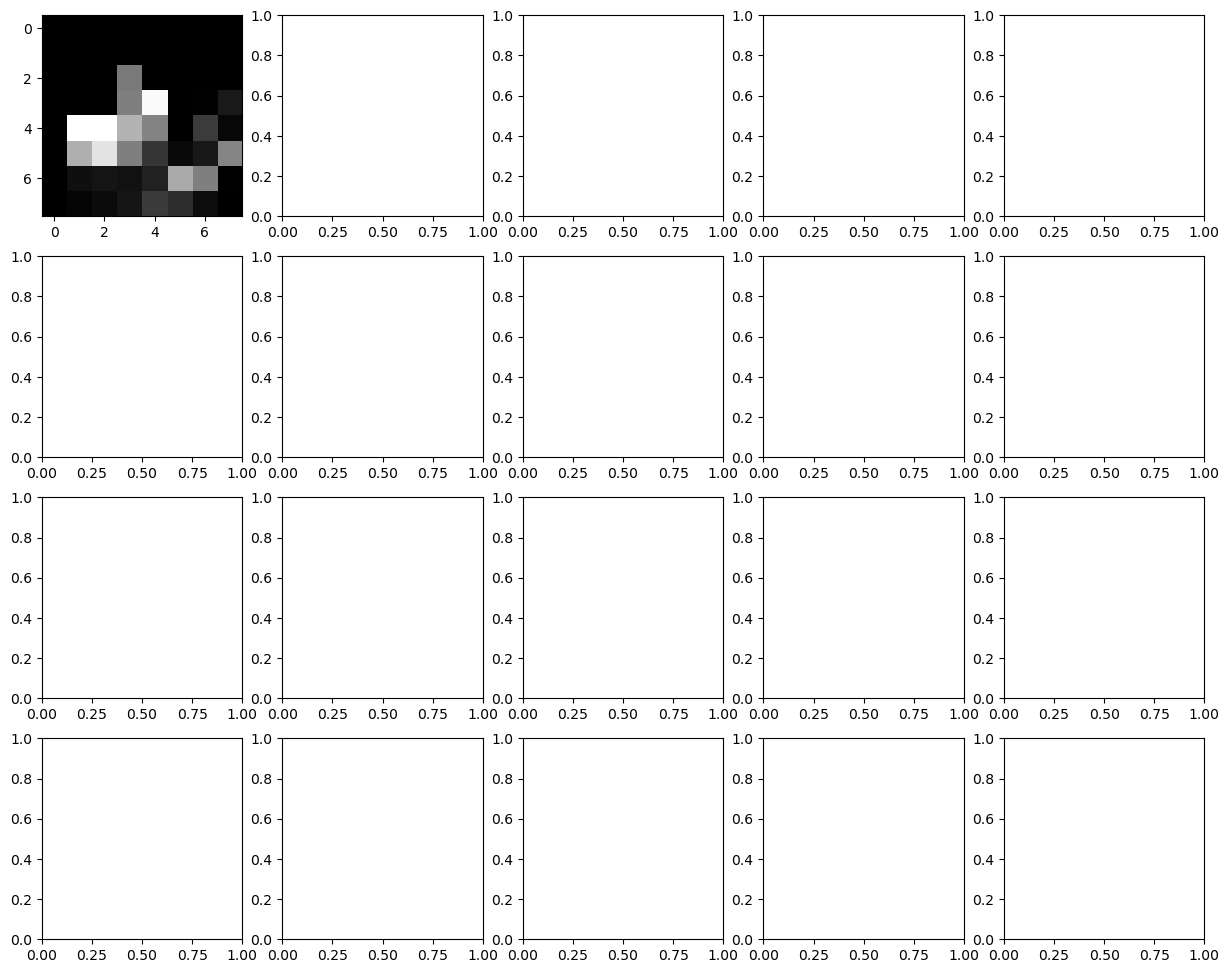

In [12]:
view_pytorch_images_grid(X_train_images, indices=np.where(y_train == 1)[0][:20], rows=4, cols=5)
# Anomaly

In [16]:
view_pytorch_images_grid(X_train_images, labels=y_train, indices=np.where(y_train == 11)[0][7:12], rows=1, cols=5)
# normal

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1500x0 with 0 Axes>

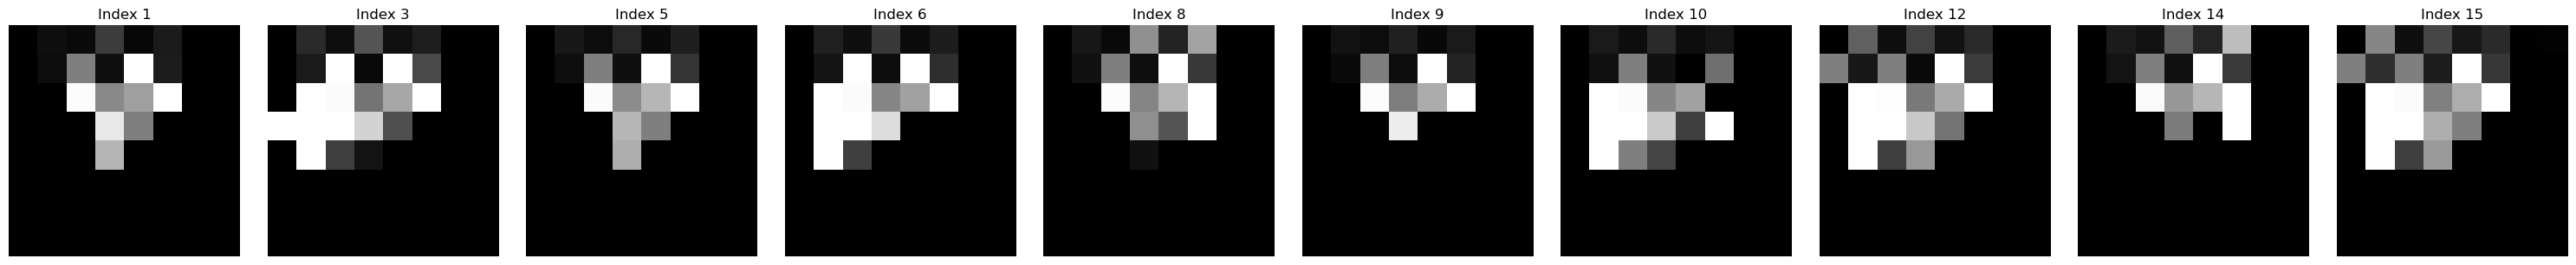

In [18]:
view_pytorch_images_grid(X_test_images, indices=np.where(y_test == 1)[0][:10], rows=1, cols=10)
# Anomaly

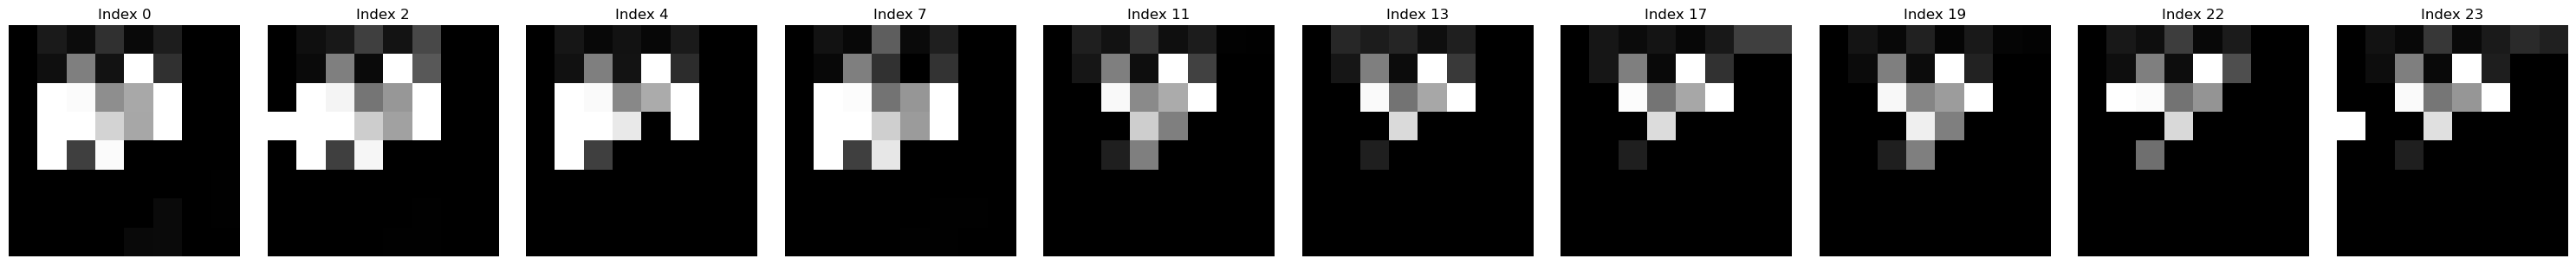

In [19]:
view_pytorch_images_grid(X_test_images, indices=np.where(y_test == 0)[0][:10], rows=1, cols=10)
# Normal

In [20]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([259964, 188771]))

# MAE Model

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [18]:
num_samples, channels, img_height, img_width = X_train_images.shape
latent_dim = 16

In [19]:
class Encoder(nn.Module):
    def __init__(self, img_channels=1, feature_dim=32, latent_dim=2):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(img_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(32 * 2 * 2, feature_dim)

    def forward(self, x):
        x = self.relu(self.conv1(x))  # Output: (batch_size, 16, 8, 8)
        x = self.pool(x)              # Output: (batch_size, 16, 4, 4)
        x = self.relu(self.conv2(x))  # Output: (batch_size, 32, 4, 4)
        x = self.pool(x)              # Output: (batch_size, 32, 2, 2)
        x = x.view(x.size(0), -1)     # Flatten to (batch_size, 128)
        x = self.fc1(x)               # Output: (batch_size, feature_dim)
        return x

In [20]:
class Decoder(nn.Module):
    def __init__(self, img_channels=1, feature_dim=32):
        super(Decoder, self).__init__()
        self.fc2 = nn.Linear(feature_dim, 32 * 2 * 2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(16, img_channels, kernel_size=3, stride=1, padding=1)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, z):
        x = self.relu(self.fc2(z))           # Output: (batch_size, 128)
        x = x.view(x.size(0), 32, 2, 2)      # Reshape to (batch_size, 32, 2, 2)
        x = self.upsample(x)                 # Upsample to (batch_size, 32, 4, 4)
        x = self.relu(self.deconv1(x))       # Output: (batch_size, 16, 4, 4)
        x = self.upsample(x)                 # Upsample to (batch_size, 16, 8, 8)
        x = self.sigmoid(self.deconv2(x))    # Output: (batch_size, img_channels, 8, 8)
        return x

In [21]:
class MAE(nn.Module):
    def __init__(self, img_channels=1, feature_dim=32, latent_dim=2):
        super(MAE, self).__init__()
        self.encoder = Encoder(img_channels, feature_dim, latent_dim)
        self.decoder = Decoder(img_channels, feature_dim)

    def mask_input(self, x, mask_ratio=0.25):
        # Generate a mask with 0s and 1s, keeping only (1-mask_ratio) of the original input
        mask = torch.rand(x.shape, device=x.device) > mask_ratio
        x_masked = x * mask
        return x_masked, mask

    def forward(self, x, mask_ratio=0.25):
        x_masked, mask = self.mask_input(x, mask_ratio)  # Apply masking to input
        z = self.encoder(x_masked)
        reconstructed = self.decoder(z)
        return reconstructed, mask


In [22]:
def mae_loss_function(reconstructed, original, mask):
    # Only calculate reconstruction loss on the masked parts
    masked_original = original * mask
    reconstruction_loss = F.mse_loss(reconstructed, masked_original, reduction='sum')
    return reconstruction_loss

# MAE Training

In [23]:
normal_indices = np.where(y_train == 0)[0]
X_train_normal = X_train_images[normal_indices]
y_train_normal = y_train[normal_indices]

In [24]:
X_train_tensor = torch.tensor(X_train_normal, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_images, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_images, dtype=torch.float32)

/tmp/ipykernel_2034/2228886096.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train_normal, dtype=torch.float32)
/tmp/ipykernel_2034/2228886096.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test_images, dtype=torch.float32)
/tmp/ipykernel_2034/2228886096.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(X_val_images, dtype=torch.float32)


In [25]:
train_dataset = TensorDataset(X_train_tensor)
test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.long))
val_dataset = TensorDataset(X_val_tensor, torch.tensor(y_val, dtype=torch.long))

batch_size = 32 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [26]:
print(len(train_loader))
print(len(test_loader))
print(len(val_loader))

8124
4383
3506


In [27]:
model = MAE(img_channels=channels, feature_dim=32, latent_dim=latent_dim).to(device)
img_channels = X_train_tensor.shape[1]

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20

mask_ratio = 0.75

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch}/{num_epochs}', leave=True)

    for batch_idx, (data,) in progress_bar:
        data = data.to(device)

        optimizer.zero_grad()

        reconstructed, mask = model(data, mask_ratio=mask_ratio)

        loss = mae_loss_function(reconstructed, data, mask)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Average Training Loss: {avg_loss:.4f}')

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(val_loader):
            data = data.to(device)

            reconstructed, mask = model(data, mask_ratio=mask_ratio)
            loss = mae_loss_function(reconstructed, data, mask)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f'Epoch {epoch}, Average Validation Loss: {avg_val_loss:.4f}')

Epoch 1/20: 100%|██████████| 8124/8124 [00:19<00:00, 420.64it/s]


Epoch 1, Average Training Loss: 5.1099
Epoch 1, Average Validation Loss: 2.1184


Epoch 2/20: 100%|██████████| 8124/8124 [00:18<00:00, 427.85it/s]


Epoch 2, Average Training Loss: 1.1611
Epoch 2, Average Validation Loss: 1.1557


Epoch 3/20: 100%|██████████| 8124/8124 [00:18<00:00, 432.50it/s]


Epoch 3, Average Training Loss: 0.7069
Epoch 3, Average Validation Loss: 0.9198


Epoch 4/20: 100%|██████████| 8124/8124 [00:18<00:00, 435.39it/s]


Epoch 4, Average Training Loss: 0.5966
Epoch 4, Average Validation Loss: 0.8573


Epoch 5/20: 100%|██████████| 8124/8124 [00:18<00:00, 440.72it/s]


Epoch 5, Average Training Loss: 0.5446
Epoch 5, Average Validation Loss: 0.7938


Epoch 6/20: 100%|██████████| 8124/8124 [00:18<00:00, 430.18it/s]


Epoch 6, Average Training Loss: 0.5123
Epoch 6, Average Validation Loss: 0.7598


Epoch 7/20: 100%|██████████| 8124/8124 [00:18<00:00, 431.24it/s]


Epoch 7, Average Training Loss: 0.4894
Epoch 7, Average Validation Loss: 0.7446


Epoch 8/20: 100%|██████████| 8124/8124 [00:18<00:00, 430.98it/s]


Epoch 8, Average Training Loss: 0.4692
Epoch 8, Average Validation Loss: 0.7358


Epoch 9/20: 100%|██████████| 8124/8124 [00:18<00:00, 436.18it/s]


Epoch 9, Average Training Loss: 0.4570
Epoch 9, Average Validation Loss: 0.7000


Epoch 10/20: 100%|██████████| 8124/8124 [00:18<00:00, 445.68it/s]


Epoch 10, Average Training Loss: 0.4475
Epoch 10, Average Validation Loss: 0.7065


Epoch 11/20: 100%|██████████| 8124/8124 [00:18<00:00, 437.96it/s]


Epoch 11, Average Training Loss: 0.4348
Epoch 11, Average Validation Loss: 0.7061


Epoch 12/20: 100%|██████████| 8124/8124 [00:18<00:00, 432.32it/s]


Epoch 12, Average Training Loss: 0.4253
Epoch 12, Average Validation Loss: 0.6798


Epoch 13/20: 100%|██████████| 8124/8124 [00:18<00:00, 450.17it/s]


Epoch 13, Average Training Loss: 0.4168
Epoch 13, Average Validation Loss: 0.6692


Epoch 14/20: 100%|██████████| 8124/8124 [00:17<00:00, 455.53it/s]


Epoch 14, Average Training Loss: 0.4110
Epoch 14, Average Validation Loss: 0.6518


Epoch 15/20: 100%|██████████| 8124/8124 [00:17<00:00, 453.52it/s]


Epoch 15, Average Training Loss: 0.4039
Epoch 15, Average Validation Loss: 0.6542


Epoch 16/20: 100%|██████████| 8124/8124 [00:18<00:00, 446.58it/s]


Epoch 16, Average Training Loss: 0.4008
Epoch 16, Average Validation Loss: 0.6308


Epoch 17/20: 100%|██████████| 8124/8124 [00:18<00:00, 446.64it/s]


Epoch 17, Average Training Loss: 0.3963
Epoch 17, Average Validation Loss: 0.6343


Epoch 18/20: 100%|██████████| 8124/8124 [00:17<00:00, 451.42it/s]


Epoch 18, Average Training Loss: 0.3902
Epoch 18, Average Validation Loss: 0.6336


Epoch 19/20: 100%|██████████| 8124/8124 [00:17<00:00, 459.37it/s]


Epoch 19, Average Training Loss: 0.3857
Epoch 19, Average Validation Loss: 0.6156


Epoch 20/20: 100%|██████████| 8124/8124 [00:17<00:00, 455.94it/s]


Epoch 20, Average Training Loss: 0.3814
Epoch 20, Average Validation Loss: 0.6090


In [28]:
torch.save(model.state_dict(), "deepinsight_mae_normal_norf.pth")

# Reconstruction Classification

In [46]:
model = MAE(img_channels=3, feature_dim=32, latent_dim=16).to(device)
model.load_state_dict(torch.load("deepinsight_mae_normal.pth"))

<All keys matched successfully>

In [47]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve
)

In [110]:
def compute_reconstruction_errors(model, data_loader, mask_ratio=0.75):
    model.eval()
    reconstruction_errors = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='evaluating'):
            if len(batch) == 1:
                data = batch[0]
            elif len(batch) == 2:
                data, label = batch
                labels.extend(label.cpu().numpy())
            else:
                raise ValueError("Unexpected batch size. Expected 1 or 2 elements in batch.")

            data = data.to(device)
            
            reconstructed, mask = model(data, mask_ratio=mask_ratio)
            loss = F.mse_loss(reconstructed, data, reduction='sum')

            mask = mask.float()
            mask = mask.expand_as(data)

            loss = loss * (1 - mask)

            loss = loss.view(loss.size(0), -1).mean(dim=1) 
            reconstruction_errors.extend(loss.cpu().numpy())

    return np.array(reconstruction_errors)#, np.array(labels)

In [111]:
reconstruction_errors_train = compute_reconstruction_errors(model, train_loader)
reconstruction_errors_val = compute_reconstruction_errors(model, val_loader)
reconstruction_errors_test = compute_reconstruction_errors(model, test_loader)

evaluating: 100%|██████████| 4383/4383 [00:05<00:00, 875.66it/s]


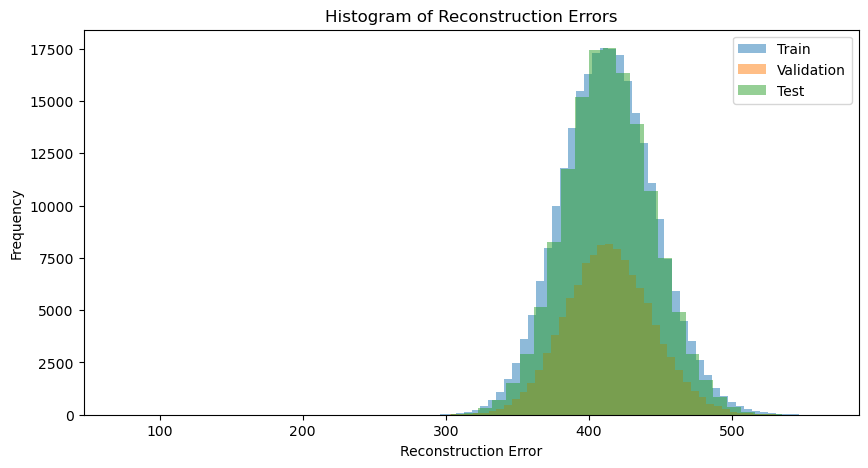

In [112]:
# Plot histograms of reconstruction errors
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_errors_train, bins=50, alpha=0.5, label='Train')
plt.hist(reconstruction_errors_val, bins=50, alpha=0.5, label='Validation')
plt.hist(reconstruction_errors_test, bins=50, alpha=0.5, label='Test')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Reconstruction Errors')
plt.show()

In [115]:
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_errors_test)
roc_auc = auc(fpr, tpr)

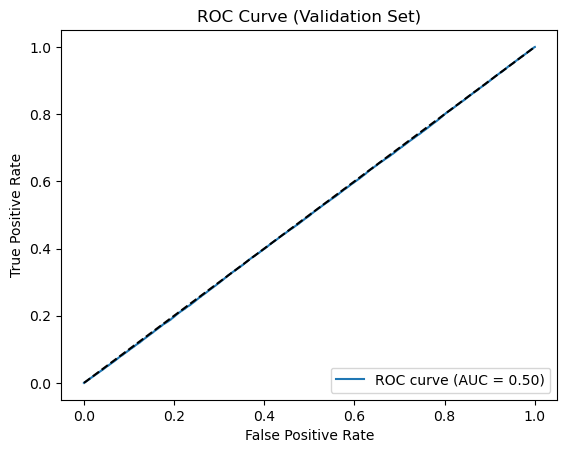

In [116]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Validation Set)')
plt.legend(loc='lower right')
plt.show()

In [41]:
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_errors_test)
roc_auc = auc(fpr, tpr)

f1_scores = []
for threshold in tqdm(thresholds, desc="evaluating thresholds"):
    y_pred = (reconstruction_errors_test >= threshold).astype(int)  # Convert to binary prediction
    f1 = f1_score(y_test, y_pred, average='binary')
    f1_scores.append(f1)

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal Threshold for F1 score: {optimal_threshold}')

evaluating thresholds: 100%|██████████| 27603/27603 [08:37<00:00, 53.33it/s]

Optimal Threshold for F1 score: 0.0164073146879673


In [43]:
y_pred = (reconstruction_errors_test > optimal_threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall_macro = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1_macro = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision (binary): {precision_macro:.4f}')
print(f'Recall (binary): {recall_macro:.4f}')
print(f'F1 Score (binary): {f1_macro:.4f}')

Accuracy: 0.8803
Precision (binary): 0.8801
Recall (binary): 0.8803
F1 Score (binary): 0.8801
